In [342]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D, LSTM, SimpleRNN, LSTMCell

np.set_printoptions(edgeitems=np.inf)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



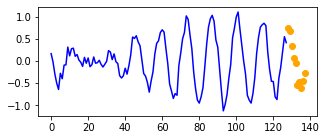

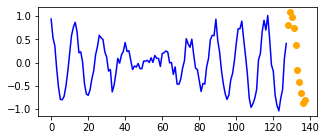

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [343]:
np.random.seed(1)
seq_length = 128
look_ahead =  10


def gen_data(size=1000, noise=0.1):
    s = seq_length + look_ahead
    d = np.zeros((size, s,1))
    for i in range(size):
        start = np.random.uniform(0, 2*np.pi)
        d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
    return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
x0 = X[:800]
y0 = Y[:800]
x2 = X[800:]
y2 = Y[800:]
for i in range(2):
    plt.figure(num=None, figsize=(5,2))  
    plt.plot(range(0, seq_length),X[i,:,0],'b-')
    plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate

In [344]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]

In [388]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelA = Sequential()
modelA.add(Convolution1D(32, kernel_size=5, strides=1, batch_input_shape=(None, None, 1), padding='same'))
modelA.add(Convolution1D(32, kernel_size=5, strides=1, padding='same'))
modelA.add(Convolution1D(32, kernel_size=5, strides=1, padding='same'))
modelA.add(Convolution1D(32, kernel_size=5, strides=1, padding='same'))
modelA.add(Dense(1))
modelA.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelA.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelA.summary()

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_139 (Conv1D)          (None, None, 32)          192       
_________________________________________________________________
conv1d_140 (Conv1D)          (None, None, 32)          5152      
_________________________________________________________________
conv1d_141 (Conv1D)          (None, None, 32)          5152      
_________________________________________________________________
conv1d_142 (Conv1D)          (None, None, 32)          5152      
_________________________________________________________________
dense_95 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_49 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
________________________________________________

In [389]:
history = modelA.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 782us/sample - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 2/50
800/800 [==============================] - 0s 290us/sample - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 3/50
800/800 [==============================] - 0s 352us/sample - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 4/50
800/800 [==============================] - 0s 499us/sample - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 5/50
800/800 [==============================] - 0s 396us/sample - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 6/50
800/800 [==============================] - 0s 385us/sample - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 7/50
800/800 [==============================] - 0s 484us/sample - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0156 - val_mse: 0.0156
Ep

Train MSE: 0.015947739221155645
Validate MSE: 0.015284504368901252


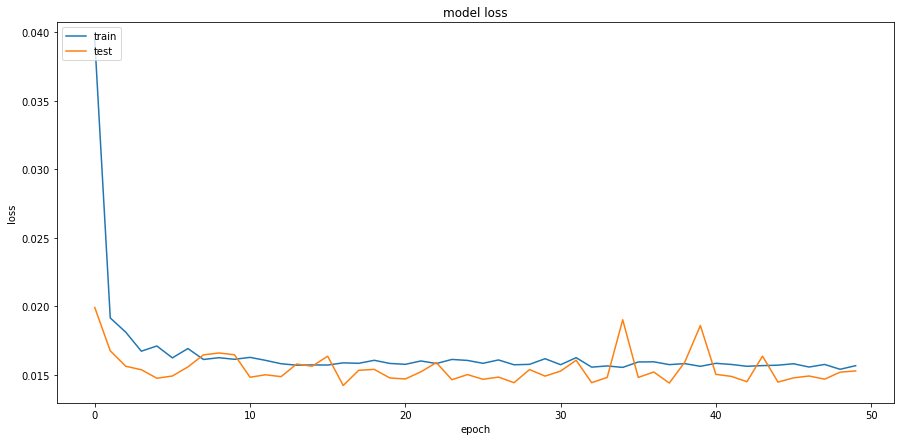

In [390]:
score_train = modelA.evaluate(x0, y0, verbose=0)
score_val = modelA.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

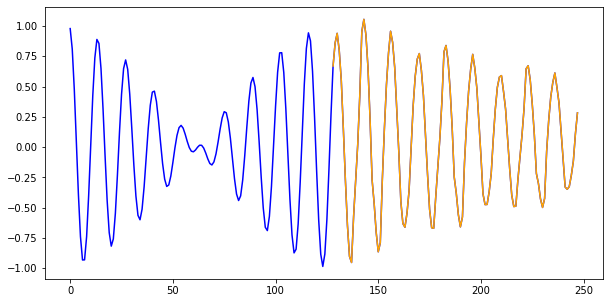

In [391]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelA.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

## B) 1D Convolution with dilation rate

In [349]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelB = Sequential()
modelB.add(Convolution1D(32, kernel_size=5, strides=1, batch_input_shape=(None, None, 1), padding='causal', dilation_rate=1))
modelB.add(Convolution1D(32, kernel_size=5, strides=1, padding='causal', dilation_rate=2))
modelB.add(Convolution1D(32, kernel_size=5, strides=1, padding='causal', dilation_rate=4))
modelB.add(Convolution1D(32, kernel_size=5, strides=1, padding='causal', dilation_rate=8))
modelB.add(Dense(1))
modelB.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelB.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelB.summary()

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_127 (Conv1D)          (None, None, 32)          192       
_________________________________________________________________
conv1d_128 (Conv1D)          (None, None, 32)          5152      
_________________________________________________________________
conv1d_129 (Conv1D)          (None, None, 32)          5152      
_________________________________________________________________
conv1d_130 (Conv1D)          (None, None, 32)          5152      
_________________________________________________________________
dense_85 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_39 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
________________________________________________

In [350]:
history = modelB.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 1s 1ms/sample - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 2/50
800/800 [==============================] - 0s 319us/sample - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 3/50
800/800 [==============================] - 0s 388us/sample - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 4/50
800/800 [==============================] - 0s 418us/sample - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5/50
800/800 [==============================] - 0s 412us/sample - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 6/50
800/800 [==============================] - 0s 306us/sample - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 7/50
800/800 [==============================] - 0s 399us/sample - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0126 - val_mse: 0.0126
Epoc

Train MSE: 0.012033826932311057
Validate MSE: 0.011103891357779503


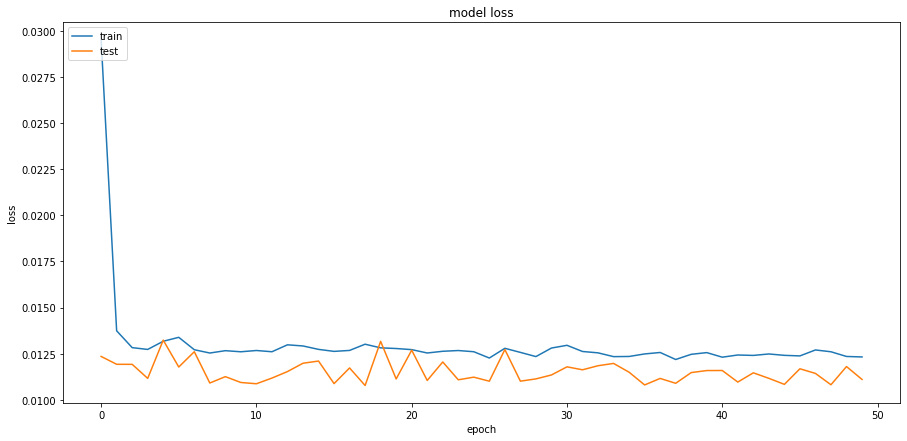

In [351]:
score_train = modelB.evaluate(x0, y0, verbose=0)
score_val = modelB.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

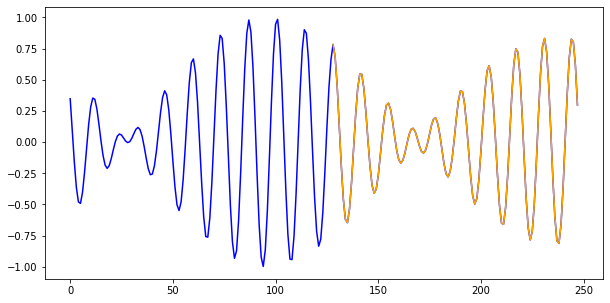

In [373]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelB.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

## C) Simple RNN

### C1)

In [356]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelC1 = Sequential()
modelC1.add(SimpleRNN(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelC1.add(Dense(1))
modelC1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelC1.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelC1.summary()

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_72 (SimpleRNN)    (None, None, 12)          168       
_________________________________________________________________
dense_87 (Dense)             (None, None, 1)           13        
_________________________________________________________________
lambda_41 (Lambda)           (None, None, 1)           0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [357]:
history = modelC1.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 4s 5ms/sample - loss: 0.1855 - mse: 0.1855 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 2/50
800/800 [==============================] - 3s 4ms/sample - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 3/50
800/800 [==============================] - 3s 4ms/sample - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 4/50
800/800 [==============================] - 3s 4ms/sample - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/50
800/800 [==============================] - 3s 4ms/sample - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 6/50
800/800 [==============================] - 3s 4ms/sample - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 7/50
800/800 [==============================] - 3s 4ms/sample - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 8/50
800/8

Train MSE: 0.024370937198400496
Validate MSE: 0.02377374716103077


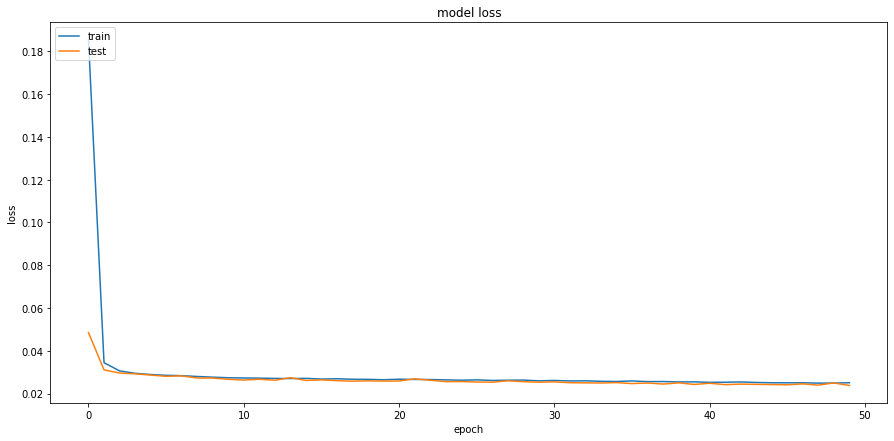

In [358]:
score_train = modelC1.evaluate(x0, y0, verbose=0)
score_val = modelC1.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

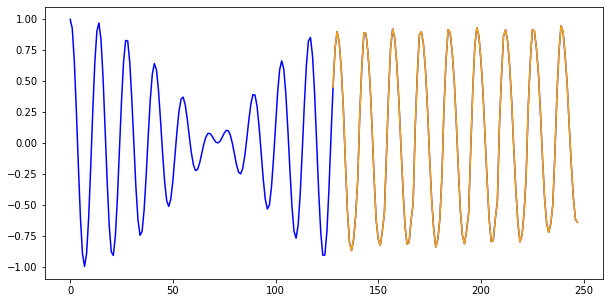

In [374]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelC1.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

### C2)

In [360]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelC2 = Sequential()
modelC2.add(SimpleRNN(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelC2.add(SimpleRNN(units=24, return_sequences=True, activation="relu"))
modelC2.add(SimpleRNN(units=48, return_sequences=True, activation="relu"))
modelC2.add(Dense(1))
modelC2.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelC2.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelC2.summary()

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_73 (SimpleRNN)    (None, None, 12)          168       
_________________________________________________________________
simple_rnn_74 (SimpleRNN)    (None, None, 24)          888       
_________________________________________________________________
simple_rnn_75 (SimpleRNN)    (None, None, 48)          3504      
_________________________________________________________________
dense_88 (Dense)             (None, None, 1)           49        
_________________________________________________________________
lambda_42 (Lambda)           (None, None, 1)           0         
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [361]:
history = modelC2.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 10s 13ms/sample - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 2/50
800/800 [==============================] - 9s 11ms/sample - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 3/50
800/800 [==============================] - 9s 11ms/sample - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 4/50
800/800 [==============================] - 9s 11ms/sample - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 5/50
800/800 [==============================] - 9s 11ms/sample - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 6/50
800/800 [==============================] - 9s 11ms/sample - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 7/50
800/800 [==============================] - 9s 11ms/sample - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 8/

Train MSE: 0.020348583161830903
Validate MSE: 0.02054134078323841


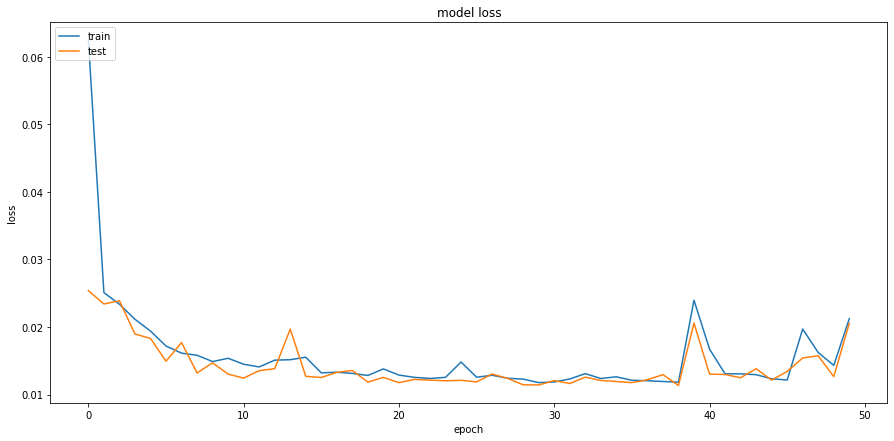

In [362]:
score_train = modelC2.evaluate(x0, y0, verbose=0)
score_val = modelC2.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

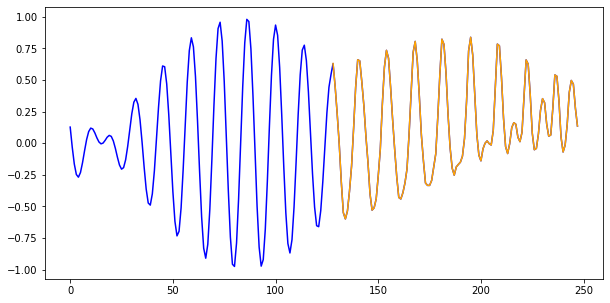

In [375]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelC2.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

## D) LSTM Cell

### D1)

In [364]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelD1 = Sequential()
modelD1.add(LSTM(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelD1.add(Dense(1))
modelD1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelD1.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelD1.summary()

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 12)          672       
_________________________________________________________________
dense_89 (Dense)             (None, None, 1)           13        
_________________________________________________________________
lambda_43 (Lambda)           (None, None, 1)           0         
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [365]:
history = modelD1.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 7s 9ms/sample - loss: 0.2577 - mse: 0.2577 - val_loss: 0.1647 - val_mse: 0.1647
Epoch 2/50
800/800 [==============================] - 6s 8ms/sample - loss: 0.1472 - mse: 0.1472 - val_loss: 0.1248 - val_mse: 0.1248
Epoch 3/50
800/800 [==============================] - 6s 8ms/sample - loss: 0.1106 - mse: 0.1106 - val_loss: 0.0915 - val_mse: 0.0915
Epoch 4/50
800/800 [==============================] - 6s 8ms/sample - loss: 0.0797 - mse: 0.0797 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 5/50
800/800 [==============================] - 6s 8ms/sample - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 6/50
800/800 [==============================] - 6s 8ms/sample - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 7/50
800/800 [==============================] - 6s 8ms/sample - loss: 0.0411 - mse: 0.0411 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 8/50
800/8

Train MSE: 0.02609816923737526
Validate MSE: 0.025319472923874854


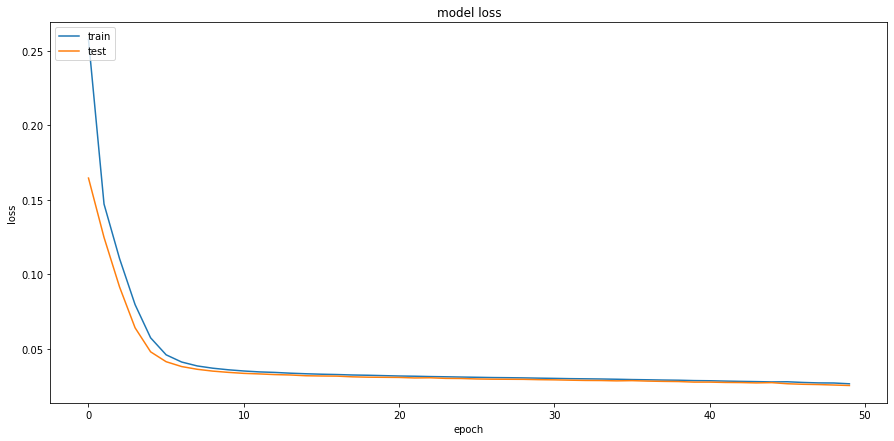

In [366]:
score_train = modelD1.evaluate(x0, y0, verbose=0)
score_val = modelD1.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

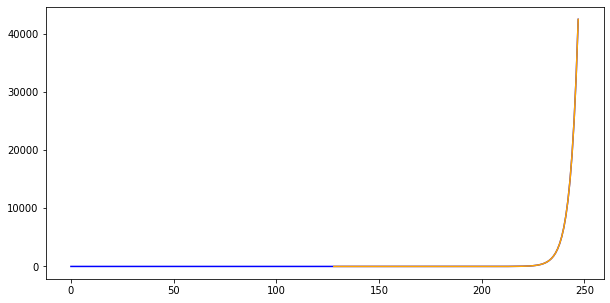

In [376]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelD1.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

### D2)

In [379]:
n_epochs = 10
batch_size = 8
lr = 1e-3
look_ahead = 10

modelD2 = Sequential()
modelD2.add(LSTM(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelD2.add(LSTM(units=6, return_sequences=True, activation="relu"))
modelD2.add(LSTM(units=3, return_sequences=True, activation="relu"))
modelD2.add(Dense(1))
modelD2.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelD2.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelD2.summary()

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 12)          672       
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 6)           456       
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 3)           120       
_________________________________________________________________
dense_92 (Dense)             (None, None, 1)           4         
_________________________________________________________________
lambda_46 (Lambda)           (None, None, 1)           0         
Total params: 1,252
Trainable params: 1,252
Non-trainable params: 0
_________________________________________________________________


In [380]:
history = modelD2.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 20s 25ms/sample - loss: 0.2776 - mse: 0.2776 - val_loss: 0.2640 - val_mse: 0.2640
Epoch 2/10
800/800 [==============================] - 17s 21ms/sample - loss: 0.8014 - mse: 0.8014 - val_loss: 0.1861 - val_mse: 0.1861
Epoch 3/10
800/800 [==============================] - 17s 21ms/sample - loss: 0.1630 - mse: 0.1630 - val_loss: 0.1338 - val_mse: 0.1338
Epoch 4/10
800/800 [==============================] - 17s 21ms/sample - loss: 0.1214 - mse: 0.1214 - val_loss: 0.1060 - val_mse: 0.1060
Epoch 5/10
800/800 [==============================] - 17s 21ms/sample - loss: 0.0987 - mse: 0.0987 - val_loss: 0.0888 - val_mse: 0.0888
Epoch 6/10
800/800 [==============================] - 17s 21ms/sample - loss: 0.0827 - mse: 0.0827 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 7/10
800/800 [==============================] - 17s 21ms/sample - loss: 0.0703 - mse: 0.0703 - val_loss: 0.0638 - val_mse: 0.0638
Ep

Train MSE: 0.04505834013223648
Validate MSE: 0.04443402230739593


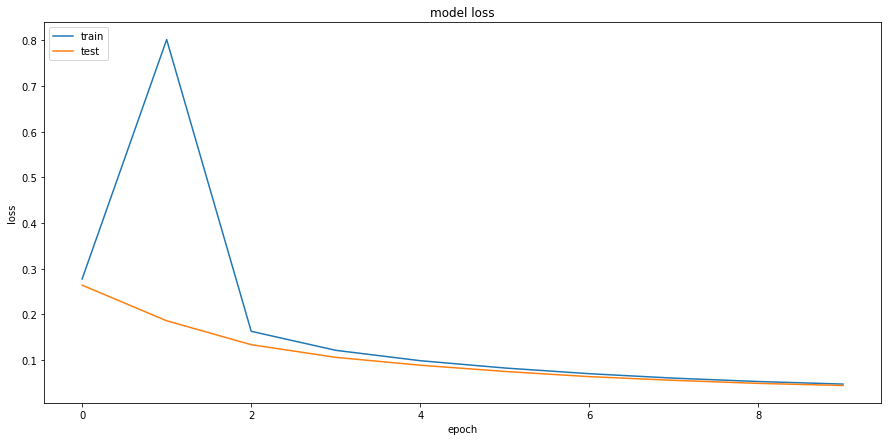

In [381]:
score_train = modelD2.evaluate(x0, y0, verbose=0)
score_val = modelD2.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

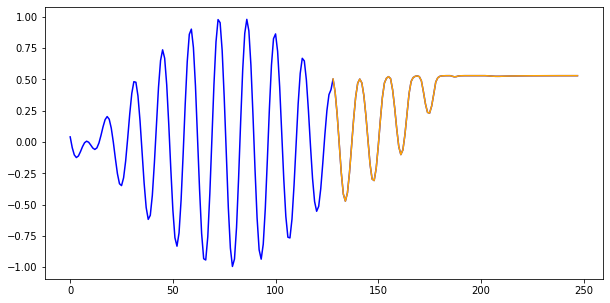

In [386]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelD2.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')